# Tunnel Current Amplitudes @ MiTMoJCo
**Dmitry R. Gulevich <br>
ITMO University, St Petersburg, Russia**

This Jupyter notebook is part of MiTMoJCo distributed under GNU General Public License v3.0. 
Using this notebook you will be able to create new fits of tunnel current amplitudes for 
arbitrary temperature, superconducting gaps and Riedel peak smoothing parameter.

### Contents:
* Section 1: Tunnel current amplitudes from BCS.
* Section 2: Smoothing Riedel peaks in tunnel current amplitudes.
* Section 3: Fitting tunnel current amplitudes by complex exponentials

### References:
1. A. I. Larkin and Yu. N. Ovchinnikov, Sov. Phys. JETP 24, 1035 (1967).
2. D. R. Gulevich, V. P. Koshelets, and F. V. Kusmartsev, Phys. Rev. B 96, 024515 (2017).
3. A. B. Zorin, I. O. Kulik, K. K. Likharev, and J. R. Schrieffer, Sov. J. Low Temp. Phys. 5, 537 (1979).
4. D. R. Gulevich, V. P. Koshelets, F. V. Kusmartsev, arXiv:1709.04052 (2017).
5. D. R. Gulevich, L. V. Filippenko, V. P. Koshelets, arXiv:1809.01642 (2018).
6. A. A. Odintsov, V. K. Semenov and A. B. Zorin, IEEE Trans. Magn. 23, 763 (1987).

## Section 1: Tunnel current amplitudes from BCS

In this section we evaluate tunnel current amplitudes from expressions calculated from BCS 
by Larkin and Ovchinnikov [1]. As the original experessions of Larkin and Ovchinnikov were 
given with a misprint, we refer readers to the verified formulas (A5)-(A8) summarized in 
Appendix of Ref.[2]. 

In the calculations we assume x>=0 without loosing 
the generality (x<0 can be obtained by symmetry). Tunnel current amplitudes are normalized to Vg/R.
    
Input:
 - Delta1 -- superconducting gap in meV
 - Delta2 -- superconducting gap in meV
 - T -- temperature in K

Output:
- Repair(x) -- real part of the pair current
- Impair(x) -- imaginary part of the pair current
- Reqp(x) -- real part of the quasiparticle current
- Imqp(x) -- imaginary part of the quasiparticle current    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import quad
import time

In [2]:
###-----------------------------------------------
### Input parameters
###-----------------------------------------------

Delta1 = 1.4 # meV
Delta2 = 2.3 # meV
T=4.2 # temperature in Kelvin

In [3]:
### define normalized gaps d1 and d2 (0 < d1 <= d2)
d1=min(Delta1,Delta2)/(Delta1+Delta2)
d2=1.-d1
Vg = 1.e-3*(Delta1+Delta2) # gap voltage in Volts
e0 = 1.6e-19 # electron charge (SI units)
kB = 1.38e-23 # Boltzmann constant (SI units)
b=e0*Vg/(2*kB*T) # parameter alpha in Ref. PRB 96, 024515 (2017)

In [4]:
### Internal variables
dd1 = d1*d1
dd2 = d2*d2
d21 = d2-d1

In [5]:
#------- Re pair current -------

def Repair_integrand_part1(y, x):	
    return np.tanh(b*abs(y))/( np.sqrt(dd1-(y-x)*(y-x)) * np.sqrt(y*y-dd2) )

def Repair_integrand_part2(y, x):
    return np.tanh(b*abs(y))/( np.sqrt(y*y-dd1) * np.sqrt(dd2-(y+x)*(y+x)) )

@np.vectorize
def Repair(x):
    if(x+d1>d2):
        part1 = quad(Repair_integrand_part1, max(x-d1,d2), x+d1, args=x, limit=200)[0]
    else:
        part1=0.
    if(-x-d2<-d1):    
        part2 = quad(Repair_integrand_part2, -x-d2, min(-x+d2,-d1), args=x, limit=200)[0]
    else:
        part2=0.
    if(-x+d2>d1):
        part3 = quad(Repair_integrand_part2, d1, -x+d2, args=x, limit=200)[0]    
    else:
        part3=0.
    return 0.5*d1*d2*(part1 + part2 + part3)

In [6]:
#------- Im pair current -------

def Impair_integrand(y, x):
    return ( np.tanh(b*(y+x)) - np.tanh(b*y) )*np.sign(y)*np.sign(y+x)/( np.sqrt(y*y-dd1) * np.sqrt((y+x)*(y+x)-dd2) )

@np.vectorize
def Impair(x):
    part1 = quad(Impair_integrand, -np.inf, min(-d1,-x-d2), args=x, limit=200)[0]
    part2 = quad(Impair_integrand, max(d1,-x+d2), np.inf, args=x, limit=200)[0]
    if(-x+d2<-d1):
        part3 = quad(Impair_integrand, -x+d2, -d1, args=x, limit=200)[0]    
    else:
        part3=0.
    return 0.5*d1*d2*(part1 + part2 + part3)   

In [7]:
#------- Re qp current -------

def Reqp_integrand_part1(y, x):
    return abs(y)*np.tanh(b*y)*(y-x)/( np.sqrt(y*y-dd1) * np.sqrt(dd2-(y-x)*(y-x)) )

def Reqp_integrand_part1b_d1_xd2(y, x):
    return abs(y)*np.tanh(b*y)*(y-x)/np.sqrt((y+d1)*(d2+y-x))

def Reqp_integrand_part1b_xd2_xd2(y, x):
    return abs(y)*np.tanh(b*y)*(y-x)/np.sqrt(y*y-dd1)

def Reqp_integrand_part2_xd1_d2(y, x):
    return abs(y)*np.tanh(b*y)*(y+x)/np.sqrt((d1-y-x)*(d2-y))

def Reqp_integrand_part2_xd1_xd1(y, x):
    return abs(y)*np.tanh(b*y)*(y+x)/np.sqrt(y*y-dd2)

@np.vectorize
def Reqp(x):
    if(x-d2<-d1):
        part1a = quad(Reqp_integrand_part1, x-d2, -d1, args=x, limit=200)[0]
    else:
        part1a = 0.           
        
    if(x-d2<d1):    
        part1b = quad(Reqp_integrand_part1b_d1_xd2, d1, x+d2, args=x, limit=200, weight='alg', wvar=(-0.5,-0.5))[0]
    else:
        part1b = quad(Reqp_integrand_part1b_xd2_xd2, x-d2, x+d2, args=x, limit=200, weight='alg', wvar=(-0.5,-0.5))[0]

    if(-x-d1<-d2):
        if(-d2<-x+d1):
            part2 = quad(Reqp_integrand_part2_xd1_d2, -x-d1, -d2, args=x, limit=200, weight='alg', wvar=(-0.5,-0.5))[0]
        else:
            part2 = quad(Reqp_integrand_part2_xd1_xd1, -x-d1, -x+d1, args=x, limit=200, weight='alg', wvar=(-0.5,-0.5))[0]
    else:
        part2 = 0.
    return -0.5*(part1a + part1b + part2)

In [8]:
#------- Im qp current -------

def Imqp_integrand(y, x):
    return ( np.tanh(b*(y+x))-np.tanh(b*y) )*abs(y)*abs(y+x)/( np.sqrt((y+x)*(y+x)-dd1) * np.sqrt(y*y-dd2) )

@np.vectorize
def Imqp(x):
    part1 = quad(Imqp_integrand, -np.inf, min(-d2,-x-d1), args=x, limit=200)[0]
    if(-x+d1<-d2):
        part2 = quad(Imqp_integrand, -x+d1, -d2, args=x, limit=200)[0]
    else:
        part2 = 0.
    part3 = quad(Imqp_integrand, d2, np.inf, args=x, limit=200)[0]
    return 0.5*(part1 + part2 + part3)

In [9]:
### data points for plotting (use 500 or more points to resolve Riedel peaks)
xpoints=np.linspace(0.001,2,500)

start_time = time.time()

print('# Calculating Rejp...')
Repair_xpoints = Repair(xpoints)

print('# Calculating Imjp...')
Impair_xpoints = Impair(xpoints)

print('# Calculating Rejqp...')
Reqp_xpoints = Reqp(xpoints)

print('# Calculating Imjqp...')
Imqp_xpoints = Imqp(xpoints)

print('# Timing: %.f' % (time.time()-start_time),' seconds')

# Calculating Rejp...
# Calculating Imjp...
# Calculating Rejqp...
# Calculating Imjqp...
# Timing: 4  seconds


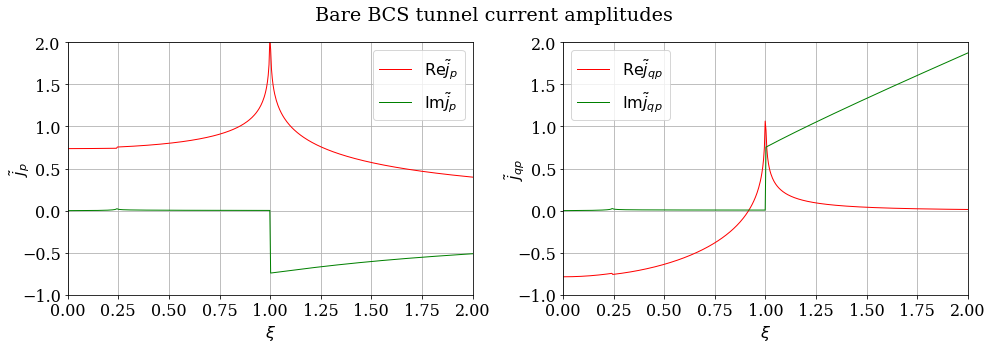

In [10]:
###--------------------------------------------------------
###   Plot BCS tunnel current amplitudes
###--------------------------------------------------------

plt.rc('font', family='serif', size=16)
fig, ax = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle("Bare BCS tunnel current amplitudes")

lw=1
ax[0].plot(xpoints,Repair_xpoints, color='r', lw=lw, label=r'${\rm Re} \tilde{j}_p$')
ax[0].plot(xpoints,Impair_xpoints, color='g', lw=lw, label=r'${\rm Im} \tilde{j}_p$')
ax[1].plot(xpoints,Reqp_xpoints, color='r', lw=lw, label=r'${\rm Re} \tilde{j}_{qp}$')
ax[1].plot(xpoints,Imqp_xpoints, color='g', lw=lw, label=r'${\rm Im} \tilde{j}_{qp}$')

ax[0].set_xlabel(r'$\xi$')
ax[0].set_ylabel(r'$\tilde{j}_p$',labelpad=-10)
ax[0].set_xlim([0,2])
ax[0].set_ylim([-1,2])

ax[1].set_xlabel(r'$\xi$')
ax[1].set_ylabel(r'$\tilde{j}_{qp}$',labelpad=-10)
ax[1].set_xlim([0,2])
ax[1].set_ylim([-1,2])

ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()

plt.tight_layout()
fig.subplots_adjust(top=0.88) # suptitle fix after tight_layout() call 

## Section 2: Smoothing Riedel peaks in tunnel current amplitudes

Smoothing Riedel peaks of bare BCS tunnel current amplitudes (TCAs). 
We apply the smoothing procedure as described in Ref. [3]. Smoothing parameter 'dsm' 
used here is equal to the parameter $\delta$ in [3]. Note, that the gaps d1 and d2 
are interchanged as compared to Ref.[3]: in our calculations we use 0<d1<d2 and
follow Refs.[2-4].

Input:
- Repair(x)
- Impair(x)
- Reqp(x)
- Imqp(x)

Output:
- Repair_smooth(x)
- Impair_smooth(x)
- Reqp_smooth(x)
- Imqp_smooth(x)
- x -- array of frequency points prepared for fitting
- Jpair_data -- complex array prepared for fitting of pair TCAs
- Jqp_data -- complex array prepared for fitting of quasiparticle TCAs

In [11]:
###-----------------------------------------------
### Input parameters
###-----------------------------------------------

dsm=0.015 # smoothing parameter delta in Ref.[3]

In [12]:
### The smoothing procedure is different for symmetric junction (d1=d2) due 
### to the difference d2-d1 appearing in the denominator: the limit d2-d1->0 is 
### taken analytically to avoid numerical errors.
if(d21<0.001):
    symmetric_junction=True
    print('# Symmetric junction assumed (Delta1=Delta2)')
else:
    symmetric_junction=False
    print('# Asymmetric junction (Delta1!=Delta2)')

# Asymmetric junction (Delta1!=Delta2)


In [13]:
### Supplementary variables
IP0=Repair(1.e-5)
expb = np.exp(b)
invexpb = 1./expb

In [14]:
### Smoothing for Repair, Reqp
def dRe(x):
    sqpos = (x-1.)*(x-1.)
    sqneg = (x+1.)*(x+1.)    
    return -x*(1./np.pi)*IP0*0.5*np.log( ((sqpos+dsm*dsm)/sqpos) * (sqneg/(sqneg+dsm*dsm)) )

In [15]:
### Smoothing for Repair, -Reqp at x=d2-d1 
def dRe_minus(x):
    return np.pi*x*np.sqrt(d1*d2)*(np.tanh(b*d2)-np.tanh(b*d1)) * 0.5*( (2./np.pi)*np.arctan((x-d21)/dsm) - np.sign(x-d21) + (2./np.pi)*np.arctan((x+d21)/dsm) - np.sign(x+d21) ) /(4.*d21)

In [16]:
### Smoothing for Impair, Imqp at x=d2-d1
def dIm_minus(x):
    square1 = (x-d21)*(x-d21)
    square2 = (x+d21)*(x+d21)    
    return -x*np.sqrt(d1*d2)*(np.tanh(b*d2)-np.tanh(b*d1))*0.5*np.log((square1+dsm*dsm)*(square2+dsm*dsm)/(square1*square2)) / (4.*d21)

In [17]:
### Smoothing for Impair, -Imqp    
def dIm(x):
    return x*0.5*IP0*((2./np.pi)*np.arctan((1.-x)/dsm) - np.sign(1.-x) + (2./np.pi)*np.arctan((1.+x)/dsm) - np.sign(1.+x))

In [18]:
### Smoothing for Impair, Imqp at d2-d1=0
def dIm_at_0(x):
    x2=x*x
    return -b*x*expb*0.5*np.log((x2+dsm*dsm)/x2)/((expb+1.)*(expb+1.))

In [19]:
### Smoothed amplitudes

if(symmetric_junction==True):
    def Repair_smooth(x):
        return Repair(x) + dRe(x)

    def Impair_smooth(x):
        return Impair(x) + dIm(x) + dIm_at_0(x)

    def Reqp_smooth(x):
        return Reqp(x) + dRe(x)

    def Imqp_smooth(x):
        return Imqp(x) - dIm(x) + dIm_at_0(x)

else:
    def Repair_smooth(x):
        return Repair(x) + dRe(x) + dRe_minus(x)

    def Impair_smooth(x):
        return Impair(x) + dIm(x) + dIm_minus(x)

    def Reqp_smooth(x):
        return Reqp(x) + dRe(x) - dRe_minus(x)

    def Imqp_smooth(x):
        return Imqp(x) - dIm(x) + dIm_minus(x)

In [20]:
###----------------------------------------------------------
###   Export data arrays for fitting: x, Jpair_data, Jqp_data
###----------------------------------------------------------

Ndata=500 # number of frequency points for fitting
print('# Number of frequency points for fitting Ndata = ', Ndata)
x=np.linspace(0.001,2.,Ndata)

start_time = time.time()

Jpair_data = Repair_smooth(x) + 1j*Impair_smooth(x)
Jqp_data = Reqp_smooth(x) + 1j*Imqp_smooth(x)

print('# Timing: %.f' % (time.time()-start_time),' seconds')

# Number of frequency points for fitting Ndata =  500
# Timing: 5  seconds


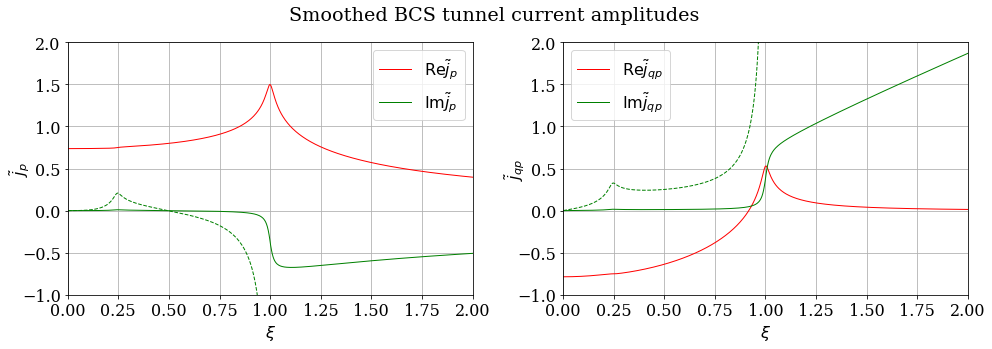

In [21]:
###--------------------------------------------------------
###   Plot smoothed tunnel current amplitudes
###--------------------------------------------------------

plt.rc('font', family='serif', size=16)
fig, ax = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle("Smoothed BCS tunnel current amplitudes")

lw=1
ax[0].plot(x,Jpair_data.real, color='r', lw=lw, label=r'${\rm Re} \tilde{j}_p$')
ax[0].plot(x,Jpair_data.imag, color='g',lw=lw, label=r'${\rm Im} \tilde{j}_p$')
ax[0].plot(x,20*Jpair_data.imag, color='g',lw=lw,ls='dashed')
ax[1].plot(x,Jqp_data.real, color='r',lw=lw, label=r'${\rm Re} \tilde{j}_{qp}$')
ax[1].plot(x,Jqp_data.imag, color='g',lw=lw, label=r'${\rm Im} \tilde{j}_{qp}$')
ax[1].plot(x,20*Jqp_data.imag, color='g',lw=lw,ls='dashed')

# s=3
# ax[0].scatter(x,Jpair_data.real, color='k', s=s)
# ax[0].scatter(x,Jpair_data.imag, color='k',s=s)
# ax[0].scatter(x,20*Jpair_data.imag, color='k',s=s)
# ax[1].scatter(x,Jqp_data.real, color='k',s=s)
# ax[1].scatter(x,Jqp_data.imag, color='k',s=s)
# ax[1].scatter(x,20*Jqp_data.imag, color='k',s=s)

ax[0].set_xlabel(r'$\xi$')
ax[0].set_ylabel(r'$\tilde{j}_p$',labelpad=-10)
ax[0].set_xlim([0,2])
ax[0].set_ylim([-1,2])

ax[1].set_xlabel(r'$\xi$')
ax[1].set_ylabel(r'$\tilde{j}_{qp}$',labelpad=-10)
ax[1].set_xlim([0,2])
ax[1].set_ylim([-1,2])

ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()

plt.tight_layout()
fig.subplots_adjust(top=0.88) # suptitle fix after tight_layout() call 

## Section 3: Fitting tunnel current amplitudes by complex exponentials

Fitting of tunnel current amplitudes by sums of complex exponentials, see Ref.[6,2].

Input:
- x -- array of frequency points prepared for fitting
- Jpair_data -- complex array prepared for fitting of pair TCAs
- Jqp_data -- complex array prepared for fitting of quasiparticle TCAs

Output:
- file containing fit parameters

In [22]:
from scipy.optimize import leastsq

In [23]:
###-----------------------------------------------
### Input parameters
###-----------------------------------------------

maxNterms = 8 # number of complex exponentials
thr = 0.2 # ratio of absolute and relative tolerances (equal to $\tau_a/\tau_r$ in Ref.[2])

In [24]:
###-----------------------------------------------
### Supplementary routines
###-----------------------------------------------

def display(cpars):
    print("p=",repr(np.vstack(rep(cpars[:Nterms].real)+1j*cpars[:Nterms].imag).flatten()))
    print("A=",repr(cpars[Nterms:2*Nterms]))
    print("B=",repr(cpars[2*Nterms:3*Nterms]))

### flatten complex array
def realimag(carray):
    return np.array([(x.real, x.imag) for x in carray]).flatten()

### form complex array
def ccombine(param_list):
    cpars = np.zeros(round(0.5*len(param_list)), dtype = complex)
    cpars.real = param_list[0:len(param_list):2]
    cpars.imag = param_list[1:len(param_list):2]
    return cpars

### Mapping of (-inf,+inf) to Re[p]<0
@np.vectorize
def rep(zeta):
    return -abs(zeta)
#    return -zeta*zeta

@np.vectorize
def invrep(xi):
    return -xi
#    return np.sqrt(-xi)

In [25]:
### Jpair model
def modelJpair(cpars, w):
    zeta = cpars[0:Nterms].real
    eta = cpars[0:Nterms].imag
    rea = cpars[Nterms:2*Nterms].real
    ima = cpars[Nterms:2*Nterms].imag
    sum=0.0;
    for n in range(Nterms):         
        ### Differs from modelJqp by w->(-w)
        sum-=(rea[n]*rep(zeta[n])+ima[n]*eta[n]-1j*w*rea[n])/(rep(zeta[n])*rep(zeta[n])+eta[n]*eta[n]-w*w-2.*1j*w*rep(zeta[n]))
    return sum

### Jqp model
def modelJqp(cpars, w):
    zeta = cpars[0:Nterms].real
    eta = cpars[0:Nterms].imag
    reb = cpars[2*Nterms:3*Nterms].real
    imb = cpars[2*Nterms:3*Nterms].imag
    sum=0.0;
    for n in range(Nterms):
        sum-=(reb[n]*rep(zeta[n])+imb[n]*eta[n]+1j*w*reb[n])/(rep(zeta[n])*rep(zeta[n])+eta[n]*eta[n]-w*w+2.*1j*w*rep(zeta[n]))
    return 1j*w + sum

In [26]:
# Relative difference with threshold thr
def Drel(X,Xref):
    return np.abs(X-Xref)/np.maximum(thr,np.abs(Xref))

In [27]:
# Residual for least square optimization
def residual(param_list):
    cpars = ccombine(param_list)
    Jpair_model = modelJpair(cpars, x)
    Jqp_model = modelJqp(cpars, x)

    ReJpair_diff = Drel(Jpair_model.real, Jpair_data.real)
    ImJpair_diff = Drel(Jpair_model.imag, Jpair_data.imag)
    ReJqp_diff = Drel(Jqp_model.real, Jqp_data.real)
    ImJqp_diff = Drel(Jqp_model.imag, Jqp_data.imag)

    return np.concatenate((ReJpair_diff,ImJpair_diff,ReJqp_diff,ImJqp_diff))

In [28]:
###----------- Fitting --------------------

p = np.array([-1.+d21*1j])
A = np.zeros(1) + 1j*np.zeros(1)
B = np.zeros(1) + 1j*np.zeros(1)
xnew=1.

Nterms = len(p)
assert len(A)==Nterms and len(B)==Nterms
zeta=invrep(p.real)+1j*p.imag
cpars=np.concatenate((zeta,A,B))

start_time = time.time()

while(Nterms<maxNterms):

    p = np.append(p,-1.+1j*xnew)
    A = np.append(A,0.+0.j)
    B = np.append(B,0.+0.j)
    
    zeta=invrep(p.real)+1j*p.imag
    cpars=np.concatenate((zeta,A,B))
    Nterms += 1
    print('# Nterms = %d with new term at frequency %f. Calculating...' % (Nterms,xnew))

    param_list = leastsq(residual, realimag(cpars), ftol=1.e-3)[0] # call to least square method
    cpars=ccombine(param_list)

    p=rep(cpars[:Nterms].real)+1j*cpars[:Nterms].imag
    A=cpars[Nterms:2*Nterms]
    B=cpars[2*Nterms:3*Nterms]

    Jpair_model = modelJpair(cpars, x)
    Jqp_model = modelJqp(cpars, x)
    ReJpair_diff = Drel(Jpair_model.real, Jpair_data.real)
    ImJpair_diff = Drel(Jpair_model.imag, Jpair_data.imag)
    ReJqp_diff = Drel(Jqp_model.real, Jqp_data.real)
    ImJqp_diff = Drel(Jqp_model.imag, Jqp_data.imag)
    ind_max = np.argmax( np.concatenate((ReJpair_diff,ImJpair_diff,ReJqp_diff,ImJqp_diff)) )
    xnew = x[ind_max%len(x)]

    display(cpars)
    print()

finish_time=time.time()

print('# Timing: %.f' % (time.time()-start_time),' seconds')

# Nterms = 2 with new term at frequency 1.000000. Calculating...
p= array([-1.01283968+0.59017797j, -0.11345194+0.99448406j])
A= array([1.36419674+0.7251208j , 0.12792551+0.01561241j])
B= array([-0.29201044+1.27532557j,  0.13719543+0.05408092j])

# Nterms = 3 with new term at frequency 0.978467. Calculating...
p= array([-1.53032827+0.43046354j, -0.04854619+1.00270838j,
       -0.30184105+0.97864324j])
A= array([1.40941986+1.25409083j, 0.04891512-0.00127682j,
       0.22374127-0.02210307j])
B= array([-0.41312493+2.57016726e+00j,  0.04588168+1.99845638e-03j,
        0.2211084 +1.71988489e-01j])

# Nterms = 4 with new term at frequency 0.986479. Calculating...
p= array([-2.3624581 +0.22652832j, -0.03253948+1.00139611j,
       -0.15627423+1.00108313j, -0.62007077+0.95090696j])
A= array([1.36406766+2.90915669e+00j, 0.02370018-1.96668965e-03j,
       0.11293856+4.67449737e-04j, 0.36392322-1.10038042e-01j])
B= array([-0.58490416+8.21850655e+00j,  0.02411973+2.26635735e-04j,
        0.11021503

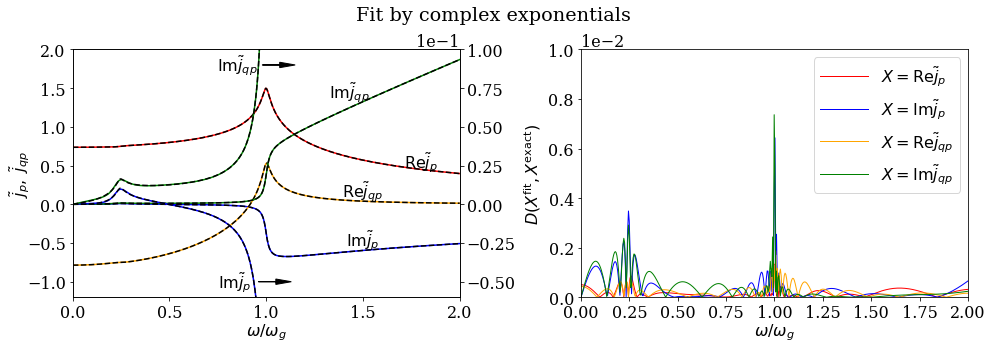

In [29]:
### ------------- Display fit -----------------

plt.rc('font', family='serif', size=16)
fig, ax = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle("Fit by complex exponentials")

# plot Re pair
ax[0].plot(x,Jpair_model.real, 'red',lw=1.5,label=r'${\rm Re} \tilde{j}_p$')
ax[0].plot(x,Jpair_data.real, 'k',lw=1.5,ls='dashed',zorder=2,label=r'$\rm exact$')

# plot Im pair
ax[0].plot(x,Jpair_model.imag, 'blue',lw=1.5,label=r'${\rm Im} \tilde{j}_p$')
ax[0].plot(x,Jpair_data.imag, 'k',lw=1.5,ls='dashed',zorder=2)

# plot Re qp
ax[0].plot(x,Jqp_model.real, 'orange',lw=1.5,label=r'${\rm Re} \tilde{j}_{qp}$')
ax[0].plot(x,Jqp_data.real, 'k',lw=1.5,ls='dashed',zorder=2)

# plot Im qp
ax[0].plot(x,Jqp_model.imag, 'green',lw=1.5,label=r'${\rm Im} \tilde{j}_{qp}$')
ax[0].plot(x,Jqp_data.imag, 'k',lw=1.5,ls='dashed',zorder=2)

# plot zoom of Im pair
twax0=ax[0].twinx()
twax0.set_ylim(np.array([-1.2,2])*0.05)
line3,=twax0.plot(x,Jpair_model.imag,'blue',lw=1.5,ls='solid')
twax0.plot(x,Jpair_data.imag, 'k',lw=1.5,ls='dashed',zorder=2)
twax0.tick_params(axis='y', which='major', labelsize=16)
twax0.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
twax0.set_xlim([0,2])

# plot zoom of Im qp
twax1=twax0
twax1.set_ylim(np.array([-1.2,2])*0.05)
line_Imqp30,=twax1.plot(x,Jqp_model.imag, 'green',lw=1.5,ls='solid')
twax1.plot(x,Jqp_data.imag, 'k',lw=1.5,ls='dashed',zorder=2)
twax1.tick_params(axis='y', which='major', labelsize=16)
twax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
twax1.set_xlim([0,2])

# plot arrows
ax[0].arrow(0.98, 1.8, 0.09, 0., head_width=0.07, head_length=0.08, fc='k', ec='k')
ax[0].arrow(0.96, -1, 0.09, 0., head_width=0.07, head_length=0.08, fc='k', ec='k')

# plot figure labels (a) and (b)
#ax[0].text(0.06,0.93,"(a)",transform=ax[0].transAxes,fontsize=20,horizontalalignment='center',verticalalignment='center')
#ax[1].text(0.06,0.93,"(b)",transform=ax[1].transAxes,fontsize=20,horizontalalignment='center',verticalalignment='center')

# plot labels next to the lines
ax[0].text(1.8,0.55,r'${\rm Re} \tilde{j}_p$',horizontalalignment='center',verticalalignment='center')
ax[0].text(1.5,0.17,r'${\rm Re} \tilde{j}_{qp}$',horizontalalignment='center',verticalalignment='center')
ax[0].text(1.5,-0.46,r'${\rm Im} \tilde{j}_p$',horizontalalignment='center',verticalalignment='center')
ax[0].text(1.43,1.45,r'${\rm Im} \tilde{j}_{qp}$',horizontalalignment='center',verticalalignment='center')
ax[0].text(0.84,-1.0,r'${\rm Im} \tilde{j}_p$',horizontalalignment='center',verticalalignment='center')
ax[0].text(0.85,1.8,r'${\rm Im} \tilde{j}_{qp}$',horizontalalignment='center',verticalalignment='center')

# set axis properties
ax[0].set_xlabel(r'$\omega/\omega_g$',labelpad=0)
ax[0].set_ylabel(r'$\tilde{j}_p,\; \tilde{j}_{qp}$',labelpad=-5)
ax[0].set_xlim([0,2])
ax[0].set_ylim([-1.2,2])
ax[0].set_xticks([0,0.5,1.0,1.5,2.0])

# plot relative errors
l1,=ax[1].plot(x,Drel(Jpair_model.real,Jpair_data.real), 'r',lw=1,ls='solid',label=r'$X={\rm Re} \tilde{j}_{p}$')
l2,=ax[1].plot(x,Drel(Jpair_model.imag,Jpair_data.imag), 'b',lw=1,ls='solid',label=r'$X={\rm Im} \tilde{j}_{p}$')
l3,=ax[1].plot(x,Drel(Jqp_model.real,Jqp_data.real), 'orange',ls='solid',lw=1,label=r'$X={\rm Re} \tilde{j}_{qp}$')
l4,=ax[1].plot(x,Drel(Jqp_model.imag,Jqp_data.imag), 'g', ls='solid',lw=1,label=r'$X={\rm Im} \tilde{j}_{qp}$')

ax[1].set_xlabel(r'$\omega/\omega_g$',labelpad=0)
ax[1].set_ylabel(r'$D(X^{\rm fit},X^{\rm exact})$',labelpad=5)
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].set_xlim([0,2])
ax[1].set_ylim([0,1e-2])
ax[1].legend(handles=[l1,l2,l3,l4], loc='upper right',fontsize=16,ncol=1,handlelength=3)

plt.tight_layout()
fig.subplots_adjust(top=0.86) # suptitle fix after tight_layout() call 
#plt.savefig("tunnel_current_amplitudes.png") # save figure to png

In [30]:
# Save parameters p,A,B to file
def parsave(filename):
    np.savetxt(filename,np.c_[p.real,p.imag,A.real,A.imag,B.real,B.imag],fmt='%10.6f')
    print('\n# Parameters saved to file '+filename)

parsave('tunnel_current_amplitudes.fit')


# Parameters saved to file tunnel_current_amplitudes.fit
